# Social Media Sanctions and Misinformation Sharing

## Import all the libraries that we need. 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

## Dataset Info

In [2]:
df=pd.read_csv('mosleh_et_al_data.csv')
print(df.head())
print(df.info())
print(df.describe())

   politics_sites2  politics_sites1  politics_followed  lowqual_pr2019_crowd  \
0        -0.231902        -1.168745          -0.080295              0.598883   
1         0.405261         1.060905           2.296375              0.774873   
2        -0.171067        -0.500076          -2.312730              0.548727   
3        -0.085814        -0.748035          -1.507481              0.611501   
4         0.595367         1.347730           2.010573              0.700217   

   lowqual_pr2019_fc  lowqual_afm  lowqual_mbfc  lowqual_lasser2019  \
0           0.279221     0.185315      0.292807            0.350000   
1           0.848639     0.614156      0.513147            0.975087   
2           0.242347     0.130950      0.242445            0.300000   
3           0.360119     0.180055      0.277793            0.316038   
4           0.698661     0.430655      0.554609            0.763889   

   suspended  politics_hashtag  ...  valence_neg  valence_neu  valence_pos  \
0          0  

## Crosstabulation between 'politics_hashtag' and 'suspended'

### Tabular format of the crosstabulation. 

In [3]:
crosstab = pd.crosstab(df['politics_hashtag'], df['suspended'], margins=True)

print(crosstab)

suspended            0     1   All
politics_hashtag                  
0                 4295   200  4495
1                 3623   882  4505
All               7918  1082  9000


In [4]:
trump_suspended_count = crosstab.values[1, 1]
trump_total_count = crosstab.values[1, 2]
biden_suspended_count = crosstab.values[0, 1]
biden_total_count = crosstab.values[0, 2]

trump_suspended_rate = trump_suspended_count / trump_total_count
biden_suspended_rate = biden_suspended_count / biden_total_count

suspension_ratio = trump_suspended_rate / biden_suspended_rate

print(f'Suspension Rate for Trump2020: {trump_suspended_rate}')
print(f'Suspension Rate for BidenHarris2020: {biden_suspended_rate}')
print(f'Suspension Likelihood Ratio: {suspension_ratio}')

Suspension Rate for Trump2020: 0.1957824639289678
Suspension Rate for BidenHarris2020: 0.04449388209121246
Suspension Likelihood Ratio: 4.400210876803551


We can see that the accounts using #Trump2020 were 4.4 times more likely to be suspended than those using #VoteBidenHarris2020

### We perform Chi-squared test to determine whether there is a statistically significant association between political hashtag usage (#Trump2020 and #VoteBidenHarris2020) and account suspension status on Twitter.

In [5]:
# Get the observed values without the margins (last row and column)
observed = crosstab.values[:2, :2]  

# Chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Display the results of the chi-square test
print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')

Chi-square statistic: 485.46706126582285
p-value: 1.3808204811294585e-107


The Chi-square value :458.46, indicates a very strong association between the hashtags used and the suspension status. 
The p-value that we get is very small, way lower than the typical 0.05, which tells us that the observed relationship between hashtags and suspension is highly statistically significant.

Finally we understand that accounts using #Trump2020 were much more likely to be suspended compared to those using #VoteBidenHarris2020. Also since the p-value is so small, we can confidently reject the null hypothesis, which assumes no association between the hashtags and suspension status. This means the differences in suspension rates for the two hashtags are not due to random chance but are instead indicative of a meaningful association

## We will visualize the distribution of low-quality sharing scores using two datasets: one based on professional fact-checkers and the other based on crowdsourced participants respectively.

### First Plot: Sharing Low-Quality Content by Fact-Checkers Only

The distribution for <b>politics_hashtag</b> = 0 (orange curve) reveals that this part of the population possesses a larger tendency of sharing unreliable or low-quality content as evaluated by fact checkers as it has larger z-score means. On the other hand, the distribution on <b>politics_hashtag</b> = 1 (blue curve) increases the overall mean z-scores showing that within this group the tendency of sharing low-quality content remains lower.

The precise differences that are there between the two curves state that there is a very well-defined and clear cut behavior dissimilarity between the two groups as can be seen by the professional fact checkers

In [6]:
# Filter out rows where 'lowqual_pr2019_fc' or 'lowqual_pr2019_crowd' are NaN
df_clean_fc = df.dropna(subset=['lowqual_pr2019_fc']).copy()
df_clean_crowd = df.dropna(subset=['lowqual_pr2019_crowd']).copy()

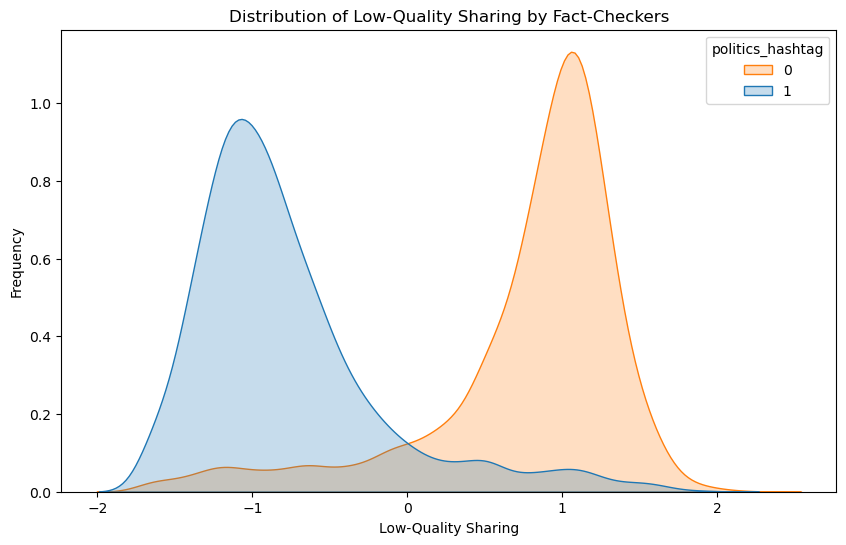

In [7]:
# Standardize the `lowqual_pr2019_fc` column using z-scores
df_clean_fc['lowqual_pr2019_fc_zscore'] = zscore(df_clean_fc['lowqual_pr2019_fc'])

# Plot the distributions of low-quality sharing by fact-checkers, grouped by politics_hashtag, using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean_fc, x='lowqual_pr2019_fc_zscore', hue='politics_hashtag', common_norm=False, fill=True)
plt.title('Distribution of Low-Quality Sharing by Fact-Checkers')
plt.xlabel('Low-Quality Sharing')
plt.ylabel('Frequency')
plt.legend(title='politics_hashtag', labels=['0', '1'])
plt.show()

### Second Plot: Sharing of Low-Quality Content By Crowdsourced Participants

Also with the first plot, the distribution for <b>politics_hashtag</b> = 0 (orange curve) is shifted to the right along the z-axis which correspondingly indicates that the people in this group are sharing more content which is of low-quality according to crowd-sourced data again. <b>politics_hashtag</b> = 1 (blue curve) maintains that expansion towards the z-axis of a lower dimension has a higher mean rating and thus it will never be detached from the professional fact checkers.

Both quotes confirm the synergy of professional fact-checkers and crowdsourced opinions because both datasets have been recorded identical trends of sharing behaviour in these two groups

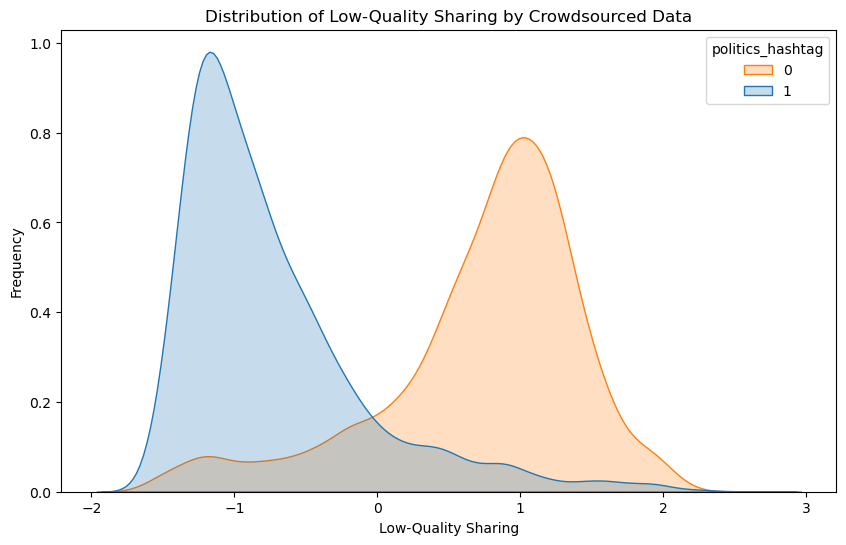

In [8]:
# Standardize the `lowqual_pr2019_crowd` column using z-scores
df_clean_crowd['lowqual_pr2019_crowd_zscore'] = zscore(df_clean_crowd['lowqual_pr2019_crowd'])

# Plot the distributions of low-quality sharing by crowdsourced participants, grouped by politics_hashtag, using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean_crowd, x='lowqual_pr2019_crowd_zscore', hue='politics_hashtag', common_norm=False, fill=True)
plt.title('Distribution of Low-Quality Sharing by Crowdsourced Data')
plt.xlabel('Low-Quality Sharing')
plt.ylabel('Frequency')
plt.legend(title='politics_hashtag', labels=['0', '1'])
plt.show()

Both distributions show a very clear difference between the groups defined by <b>politics_hashtag</b> as far as low-quality sharing scores are concerned, which is consistent across both of the datasets. These findings are consistent with those observed in the KDE and z-score standardized plots, and the patterns identified in both plots are thus deemed to be valid. With the use of KDE and z-score standardization, it was possible to present these differences vividly and gain deeper understanding of the behavioral patterns of the two groups.

### Low-Quality News Sharing on Twitter: Quantitative Analysis Using T-Test, <b>Cohen's 𝑑</b> and <b>Hedges' 𝑔</b>

We want to examine low-quality news sharing on Twitter quantitatively, based on various assessments, by performing independent sample t-tests. To evaluate the magnitude of the observed differences, effect sizes were calculated using <b>Cohen's 𝑑</b> and <b>Hedges' 𝑔</b>. These metrics provide valuable insights into the practical significance of the findings, complementing the p-values from the t-tests.

In [9]:
# Function to compute Cohen's d and Hedges' g
def cohen_hedges(group1, group2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d calculation
    d = (mean1 - mean2) / pooled_std
    
    # Hedges' g calculation (correction for small sample sizes)
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    g = correction * d
    
    return d, g

* A t-test was conducted to compare the means of low-quality sharing scores between two groups of users:
    * Group 1: Users associated with politics_hashtag = 1 (e.g., Trump-related hashtags).
    * Group 2: Users associated with politics_hashtag = 0 (e.g., Biden-related hashtags).
* The null hypothesis (𝐻0) was that there is no significant difference between the means of the two groups.
* The alternative hypothesis (𝐻𝑎) was that there is a significant difference.

We also have the standarized difference between the two means. Following the values of Cohen's can be interpretive with the correction of Cohen's 𝑑 for potential bias in small sample sizes. We testing six columns that we've been told. 

In [10]:
# Function to perform t-test and calculate effect sizes
def ttest_and_effect_size(data, column):
    # Split the data into two groups based on 'politics_hashtag'
    trump_group = data[data['politics_hashtag'] == 1][column].dropna()
    biden_group = data[data['politics_hashtag'] == 0][column].dropna()
    
    # Perform t-test
    t_stat, p_val = ttest_ind(trump_group, biden_group)
    
    # Calculate Cohen's d and Hedges' g
    cohen_d_val, hedges_g_val = cohen_hedges(trump_group, biden_group)
    
    print(f"T-test for {column}: t-stat = {t_stat}, p-value = {p_val}")
    print(f"Cohen's d for {column}: {cohen_d_val}")
    print(f"Hedges' g for {column}: {hedges_g_val}")
    print('-' * 50)

# List of columns to test
columns_to_test = [
    'lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_mbfc',
    'lowqual_lasser2019', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep'
]

# Run t-tests and effect size calculations for each column
for column in columns_to_test:
    ttest_and_effect_size(df, column)

T-test for lowqual_pr2019_fc: t-stat = 119.22334314832358, p-value = 0.0
Cohen's d for lowqual_pr2019_fc: 2.521188089789884
Hedges' g for lowqual_pr2019_fc: 2.5209766457634557
--------------------------------------------------
T-test for lowqual_afm: t-stat = 102.67771909991932, p-value = 0.0
Cohen's d for lowqual_afm: 2.164878274230793
Hedges' g for lowqual_afm: 2.1646977824757228
--------------------------------------------------
T-test for lowqual_mbfc: t-stat = 97.59223108151366, p-value = 0.0
Cohen's d for lowqual_mbfc: 2.0575402209410387
Hedges' g for lowqual_mbfc: 2.057368697316874
--------------------------------------------------
T-test for lowqual_lasser2019: t-stat = 102.63374606323765, p-value = 0.0
Cohen's d for lowqual_lasser2019: 2.1638306472835764
Hedges' g for lowqual_lasser2019: 2.163650262924173
--------------------------------------------------
T-test for lowqual_pr2019_crowd: t-stat = 102.46401373884619, p-value = 0.0
Cohen's d for lowqual_pr2019_crowd: 2.166782479

All t-tests performed were statistically significant, rejecting the null hypothesis (p < 0.0001). Such results imply that, there are substantial differences in the scores of low-quality sharing between two groups: users with certain differentiating characteristics represented by various <b>politics_hashtag</b> values. 


The <b>Cohen's 𝑑</b> and <b>Hedges' 𝑔</b> values were greater than 2.0 for most datasets and thus, categorized as huge effect sizes. This means that there is a great practical difference between the two groups in terms of low quality news sharing. In the case of <b>lowqual_pr2019_crowdrep</b>, the effect size was just a little lesser (d=1.29, g=1.29) but still comes under large category.


The low-quality news sharing behavior seems to have a strong correlation to <b>politics_hashtag</b> as can be seen from the high number of effect size in every dataset. This strengthens the claim that there are big differences in behavior, irrespective of what criterion measure is selected.

The low-quality news sharing on Twitter in terms of quantitative figures definitely showed that there was a difference between the two types defined by the <b>politics_hashtag</b>. There is a clear difference between the two groups when it comes to sharing, and as this is supported by statistical significance as well as large effect sizes over of relevant datasets, are met, it is not a surprise. This confirms earlier visually based analyses and confirms the patterns and magnitude that were observed through them.

## We will see the correlation between Lower-Quality News Sources and Conservative Ideology

On the heatmap, we visualize the pairwise correlations between six assessments of lower-quality news sharing and four measures of conservative ideology.

They linked are with all more positive, conservative this measures means across that all engagement the with measures lower that quality have news been sources considered.
The strength of the correlations is generally high (most values above 0.75), which means that there is a strong relationship between these variables.
This implies that fact-checker identified low quality sources have the best correlation with conservatism.

<b>lowqual_lasser2019</b> and <b>lowqual_afm</b> also provide high level of correlations and especially with <b>politics_sites1</b> and <b>politics_sites2</b>. lowqual_pr2019_crowdrep also has a similar pattern which suggests that crowdsourced ratings are highly correlated with the expert ratings. Republican-only Lower crowdsourced Correlation evaluations for are <b>lowqual_pr2019_crowdrep</b>: significantly lower and the ranging correlations between for 0.54 and 0.58. This suggests that the bias in this part is not as strong as in the other datasets.

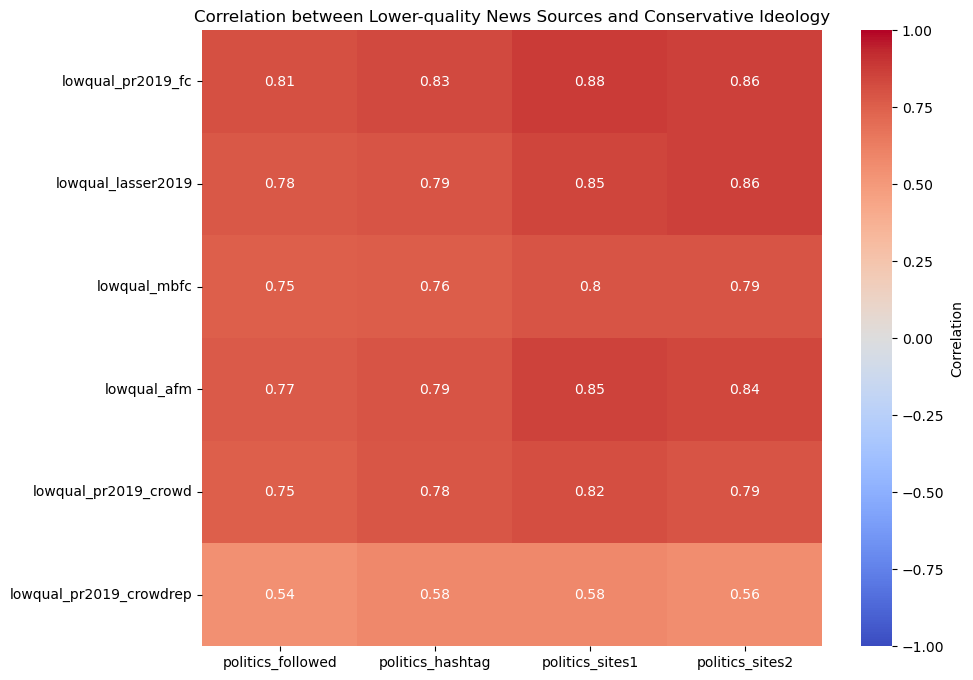

In [11]:
# Select the lower-quality news sources and conservative ideology columns
low_quality_columns = [
    'lowqual_pr2019_fc', 'lowqual_lasser2019', 'lowqual_mbfc',
    'lowqual_afm', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep'
]

political_columns = [
    'politics_followed', 'politics_hashtag', 'politics_sites1', 'politics_sites2'
]

# Filter the DataFrame to include only these columns and drop rows with missing values
df_clean_corr = df[low_quality_columns + political_columns].dropna()

# Create an empty DataFrame to store the correlation results
correlation_matrix = pd.DataFrame(index=low_quality_columns, columns=political_columns)

# Calculate the pairwise correlations manually for each combination
for low_col in low_quality_columns:
    for pol_col in political_columns:
        correlation_matrix.loc[low_col, pol_col] = df_clean_corr[low_col].corr(df_clean_corr[pol_col])

# Convert the correlation_matrix values to numeric (they may be objects due to looping)
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation between Lower-quality News Sources and Conservative Ideology')
plt.show()

The consistent associations between various assessments of conservative ideology and various measures relating to sharing low-quality news suggest that this relationship is real rather than an artefact of a single measure or dataset.
These results corroborate the earlier hypothesis that people with more conservative markers (hashtags followed, accounts followed, or shared sites) tend to share low-quality news sources irrespective of the criteria used for that evaluation.
Reported evaluations of experts like fact-checkers, MBFC, and Ad Fontes Media were found to be highly analogous in comparison to Republican-only crowdsourced evaluation which may be a biased low. This may mean that evaluations of the broader crowd tend to be more consistent with the expert opinion.

We can testify convincingly to the existence of a strong positive relationship between the two factors: people’s conservative attitudes and propensity to share lower-quality sources of news. These findings are uniform across all the three different metrics of ideology and various news quality assessments, and therefore point to a robust pattern of association. The Republican-specific crowd-sourced ratings correlation showing a slightly lower figure needs to be further understood within the context of crowd bias against those evaluations.

## We will evaluate the predictive power of different variables in determining user suspension on a social platform. The evaluation is conducted using probit regression models 

The probit model predicts the likelihood of an event (user suspension) using the cumulative normal distribution function (CDF) as its link function.
It provides a probability estimate (𝑃(𝑌=1)) based on predictors such as political orientation or low-quality news sharing.


Area Under the Curve (AUC) for Receiver Operating Characteristic (ROC) curve is used for assessing predictions.
AUC represents the ability of the model to distinguishing between users who will be suspended or not:
* 0.5: No predictive power (random chance).
* 1.0: Perfect prediction.

The results are bootstrapped over 100 iterations to provide confidence intervals (2.5th and 97.5th percentiles), accounting for variability in the data.

              Predictor  Mean AUC  Lower CI  Upper CI
0      politics_hashtag  0.679129  0.668191  0.690937
1       politics_sites1  0.700188  0.686949  0.712955
2       politics_sites2  0.704387  0.690338  0.717799
3     politics_followed  0.714457  0.698821  0.728614
4           lowqual_afm  0.716165  0.700083  0.735088
5          lowqual_mbfc  0.706012  0.694615  0.720504
6    lowqual_lasser2019  0.705477  0.693948  0.718648
7     lowqual_pr2019_fc  0.697402  0.682884  0.710294
8  lowqual_pr2019_crowd  0.684554  0.670697  0.698223


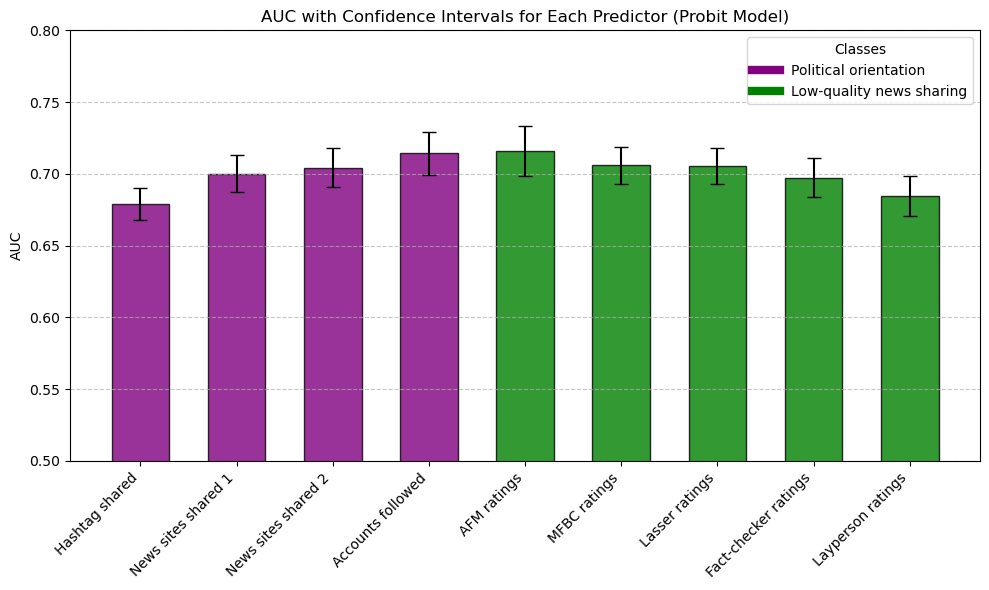

In [14]:
# List of predictors for the probit model
predictors = [
    'politics_hashtag', 'politics_sites1', 'politics_sites2',
    'politics_followed', 'lowqual_afm', 'lowqual_mbfc',
    'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd'
]

# Dependent variable
y = df['suspended']

# Store results for AUC and confidence intervals
results = []

# Number of bootstrap iterations
n_iterations = 100
random_seed = 42

# Loop over each predictor for single-predictor Probit model
for predictor in predictors:
    aucs = []
    
    # Ensure we only use rows where both predictor and target (suspended) are non-null
    predictor_data = df[[predictor, 'suspended']].dropna()
    
    if predictor_data.empty:
        print(f"Skipping predictor {predictor} due to insufficient data.")
        continue  # Skip if there's no valid data for this predictor
    
    X = predictor_data[[predictor]]
    y = predictor_data['suspended']
    
    for i in range(n_iterations):
        # Bootstrap sampling
        df_bootstrap = resample(predictor_data, replace=True, random_state=random_seed + i)
        
        # Split into predictor and response
        X_bootstrap = df_bootstrap[[predictor]]
        y_bootstrap = df_bootstrap['suspended']
        
        # Add constant term for intercept
        X_bootstrap = sm.add_constant(X_bootstrap)
        
        try:
            # Fit the Probit model
            probit_model = sm.Probit(y_bootstrap, X_bootstrap).fit(disp=0)
            # Predict probabilities
            y_pred_prob = probit_model.predict(X_bootstrap)
            # Calculate AUC
            auc = roc_auc_score(y_bootstrap, y_pred_prob)
            aucs.append(auc)
        except Exception as e:
            # Handle any errors (like perfect separation or model fitting issues)
            print(f"Error with predictor {predictor} in iteration {i}: {e}")
            aucs.append(np.nan)
    
    # Calculate mean AUC and confidence intervals (ignoring NaNs)
    if len(aucs) > 0:
        mean_auc = np.nanmean(aucs)
        lower_ci = np.nanpercentile(aucs, 2.5)
        upper_ci = np.nanpercentile(aucs, 97.5)
    else:
        mean_auc, lower_ci, upper_ci = np.nan, np.nan, np.nan
    
    # Append results
    results.append({
        'Predictor': predictor,
        'Mean AUC': mean_auc,
        'Lower CI': lower_ci,
        'Upper CI': upper_ci
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the AUC results
print(results_df)

# Define colors for each predictor type
colors = ['purple'] * 4 + ['green'] * 5  # Adjust based on predictors' grouping

# Define predictor labels for better readability
labels = [
    'Hashtag shared', 'News sites shared 1', 'News sites shared 2', 'Accounts followed',
    'AFM ratings', 'MFBC ratings', 'Lasser ratings', 'Fact-checker ratings', 'Layperson ratings'
]

plt.figure(figsize=(10, 6))
bar_positions = np.arange(len(results_df)) 
plt.bar(
    bar_positions, results_df['Mean AUC'], 
    color=colors, alpha=0.8, 
    yerr=(results_df['Upper CI'] - results_df['Lower CI']) / 2, 
    capsize=5, width=0.6, edgecolor='black'
)

plt.xticks(bar_positions, labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('AUC')
plt.ylim(0.5, 0.8) 
plt.title('AUC with Confidence Intervals for Each Predictor (Probit Model)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(
    handles=[
        plt.Line2D([0], [0], color='purple', lw=6, label='Political orientation'),
        plt.Line2D([0], [0], color='green', lw=6, label='Low-quality news sharing')
    ],
    title='Classes', loc='upper right'
)

plt.tight_layout()
plt.show()

## Results
The AUC figures for every predictor and the 95% confidence interval (CI) for each are shown in the table and the plot.

#### Top Performers:
<b>lowqual_afm</b> (AUC = 0.716, CI = [0.700, 0.735]) This is the most predictive single variable, suggesting that news-sharing users neutral or critically rated by Ad Fontes Media are at risk of being suspended.

<b>politics_followed</b> (AUC = 0.714, CI = [0.699, 0.729]) The second-highest AUC, revealing that political orientation determined by the accounts someone follows is indeed another strong predictor.

<b>politics_sites2</b> and <b>politics_sites1</b> (AUC: ~0.704 to 0.700): However, it has also been determined that sharing news sites as per the two studies mentioned above is also fragmented but still predictive.

#### Middle Performers:
<b>lowqual_mbfc</b> and <b>lowqual_lasser2019</b> (AUC ~0.706 to 0.705): Similarly predictive is sharing lower-ranked news which received poor rankings from Media Bias/Fact Check and Lasser themselves.

#### Lower Performers:
<b>politics_hashtag</b> (AUC=0.679, CI = [0.668, 0.691]). Using hashtags representing devotion to a political side or bias is less predictive compared to other political variables or even news variables.

<b>lowqual_pr2019_crowd</b> (AUC=0.685, CI=[0.671, 0.698]): On a similar note, ratings of such low-quality content by the general population can be crowdsourced to also have low predictive abilities too as compared to ratings made by experts.


#### Weakest Predictor:

<b>lowqual_pr2019_fc</b> (AUC=0.697, CI=[0.683, 0.710]) Evaluations from fact-checking organizations had very low predictive abilities as well c

All determinants linked with low quality news sharing metrics e.g. (<b>lowqual_afm, lowqual_mbfc, lowqual_lasser2019</b>) still have a better success standing than most of the political orientation metrics e.g. (<b>politics_hashtag, politics_sites1/2</b>). Imply that even in here, sharing low quality news sources is a more certain sign of suspension.


It is important to stress that the quality assessment of news provided by experts Gamson (AFM), politifact (MBFC), Lasser entails more formulation than the poodle based metrics of the sources. Therefore, expert's evaluations should be treated as gold standard.

In most cases, it is possible to state that the narrow confidence intervals of the estimates indicate strong inter-bagging results. Such a small variance indicates that the ranked order of predictors is quite stable.

The error bar plot with AUC values for individual estimates and their confidence intervals for the predictors is presented.
Colors:
* Purple: parameters determining a political orientation.
* Green: parameters of low quality news sharing.

<b>Lowqual_afm</b> and <b>politics_followed</b> indicators are the principal suspensions of this chart.

It is a fact that low quality news sharing metrics have an upper hand over political orientation metrics in terms of suspension prediction.
It can also be asserted that out of the three masters, the experts review for instance AFM possess the highest strength indicator.

## We will use multiple predictors to see if news sharing can help explain suspension

In [37]:
# Fill missing values with column means
df = df.fillna(df.mean())

# Log-transform Twitter-related metrics (adding 1 to avoid log(0))
df['log_repeated_tweet_count'] = np.log10(df['repeated_tweet_count'] + 1)
df['log_freq_pr_1h'] = np.log10(df['freq_pr_1h'] + 1)
df['log_num_followers'] = np.log10(df['num_followers'] + 1)
df['log_num_friends'] = np.log10(df['num_friends'] + 1)

# Compute `log_fol` (log10 of friends-to-followers ratio, adding 1 to avoid division by zero)
df['log_fol'] = np.log10((df['num_friends'] + 1) / (df['num_followers'] + 1))

# Winsorize variables
# Winsorize both tails for specific columns
winsorize_columns_both = [
    'valence_neg', 'valence_neu', 'valence_pos',
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]
for col in winsorize_columns_both:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

# Winsorize upper tail for specific columns
winsorize_columns_upper = [
    'moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent',
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]
for col in winsorize_columns_upper:
    df[col] = winsorize(df[col], limits=[0, 0.01])

# Dimensionality Reduction using PCA
# Define groups of variables for PCA
low_quality_vars = ['lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc']
politics_vars = ['politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2']
twitter_metrics = ['log_num_followers', 'log_num_friends', 'log_fol']
harmful_language_vars = [
    'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent',
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]
valence_vars = ['valence_neg', 'valence_neu', 'valence_pos']

# Function to perform PCA and return the first component
def compute_pca_component(df, columns, n_components=1):
    pca = PCA(n_components=n_components)
    scaled_data = StandardScaler().fit_transform(df[columns])
    pca_components = pca.fit_transform(scaled_data)
    explained_variance = pca.explained_variance_ratio_
    return pca_components[:, :n_components], explained_variance

# Compute PCA components and explained variance
df['pc1_misinfo'], var_misinfo = compute_pca_component(df, low_quality_vars)
df['pc1_politics'], var_politics = compute_pca_component(df, politics_vars)
df['pc1_fol'], var_fol = compute_pca_component(df, twitter_metrics)
harmful_language_pca, var_harmful_language = compute_pca_component(df, harmful_language_vars, n_components=3)
df['pc1_harmful_language'] = harmful_language_pca[:, 0]
df['pc2_harmful_language'] = harmful_language_pca[:, 1]
df['pc3_harmful_language'] = harmful_language_pca[:, 2]
df['pc1_valence'], var_valence = compute_pca_component(df, valence_vars)

# Compute `extremity` as the absolute value of `pc1_politics`
df['extremity'] = np.abs(df['pc1_politics'])

# Display PCA explained variance for each set of variables
explained_variance = {
    'Low-Quality News Sharing (pc1_misinfo)': var_misinfo[0],
    'Political Orientation (pc1_politics)': var_politics[0],
    'Twitter Metrics (pc1_fol)': var_fol[0],
    'Harmful Language (pc1_harmful_language)': var_harmful_language[:3],
    'Valence (pc1_valence)': var_valence[0]
}

# Print explained variance
print("Explained Variance Ratios:")
for key, value in explained_variance.items():
    print(f"{key}: {value}")

Explained Variance Ratios:
Low-Quality News Sharing (pc1_misinfo): 0.8725595303656105
Political Orientation (pc1_politics): 0.8795293696695514
Twitter Metrics (pc1_fol): 0.685296906477826
Harmful Language (pc1_harmful_language): [0.5616608  0.11871792 0.10703707]
Valence (pc1_valence): 0.7079432048725174


### Dimensionality Reduction Using PCA
Principal Component Analysis (PCA) reduces the dimensionality of variable groups, summarizing them into principal components (PCs):
1. **Low-Quality News Sharing (`pc1_misinfo`)**: Explains 87.3% of the variance in related variables.
2. **Political Orientation (`pc1_politics`)**: Captures 87.9% of the variance in political metrics.
3. **Twitter Metrics (`pc1_fol`)**: Accounts for 68.5% of variance across follower/friend metrics.
4. **Harmful Language**: Requires 3 components to explain 78.6% of the variance, reflecting the complexity and diversity of harmful content metrics.
5. **Valence (`pc1_valence`)**: Explains 70.8% of the variance in emotional valence metrics.

**Why Use Three Components for Harmful Language?**
- Harmful language encompasses varied metrics (toxicity, abuse, threats, etc.) that are not highly correlated.
- The first component (`pc1_harmful_language`) captures general harmfulness, but additional components (`pc2_harmful_language`, `pc3_harmful_language`) capture nuances like specific types of harmful content or outliers.

* Low-Quality News Sharing : Variance Explained: ~87.3%
  This means that the first principal component virtually reduces most of the variability present in the low-quality news sharing metrics. These  variables are highly inter-correlated which makes PCA suitable for such variables
* Political Orientation (pc1_politics): Variance Explained: ~87.9%
  Political orientation has a strong correlation as well with one another and the first principal component capture most of their variation. This implies that pc1_politics is a very good predictor of political orientation.

* Twitter Metrics (pc1_fol) : Variance Explained: ~68.5%
  The Twitter related variables (log_num_followers, log_num_friends and log_fol) do correlate to an extent but less to previous groups. This implies that there is still some variation in these features that has not been captured by pc1_fol.

* Harmful Language (pc1_harmful_language, pc2_harmful_language, pc3_harmful_language)
    * Variance Explained by PC1: ~56.2% </n>
    * Variance Explained by PC2: ~11.9% </n>
    * Variance Explained by PC3: ~10.7%
  
  Harmful language has a varying metric and does not have a very strong relationship; hence more than one component is able to explain a sizeable percentage of variance in the metric. Although pc1_harmful_language captures the greatest percentage, she still remains significant variability within the data set and including additional composite would assist variable understanding.
* Valence (pc1_valence): ~70.8%
  The main valence component explains about 70.8% of the variation in the data. This means it captures a big chunk of the overall information related to valence.

#### Results:
Some sets of variables, like those about low-quality news sharing or political orientation, are closely connected. They can be combined into one summary feature. Other groups, like harmful language, are more complex and need more than one feature to represent them well.

Using PCA (a technique to simplify data), new features like pc1_misinfo and pc1_politics are created. These help reduce the number of variables and might make analysis or predictions better and faster.

Variables that are strongly related can be combined effectively with fewer features. But when variables are more diverse, you need more features to capture all the details.

One feature, based on pc1_politics, measures how extreme someone’s political views are compared to the center. This can be useful for deeper analysis.

### Normalization of Independent Variables
- **Normalized Variables**: Z-scores were calculated for 16 key variables, including PCA components and engineered features.

In [38]:
# List of independent variables to normalize
independent_vars = [
    'pc1_misinfo', 'pc1_politics', 'pc1_fol',
    'pc1_harmful_language', 'pc2_harmful_language', 'pc3_harmful_language',
    'pc1_valence', 'extremity', 'tweets_in_2wk', 'botsentinel_score',
    'liwc_political', 'log_freq_pr_1h', 'log_repeated_tweet_count',
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

# Normalize the variables and add z-scored columns to the dataframe
for var in independent_vars:
    df[f'{var}_z'] = zscore(df[var])

# Display the first few rows to confirm normalization
print(df.head())

   politics_sites2  politics_sites1  politics_followed  lowqual_pr2019_crowd  \
0        -1.125898        -1.323121          -0.080295             -0.542795   
1         0.960542         1.164852           2.296375              1.904431   
2        -0.926689        -0.576981          -2.312730             -1.240244   
3        -0.647522        -0.853669          -1.507481             -0.367339   
4         1.583059         1.484908           2.010573              0.866301   

   lowqual_pr2019_fc  lowqual_afm  lowqual_mbfc  lowqual_lasser2019  \
0          -0.784788    -0.777449     -1.021676            0.350000   
1           1.602424     2.920728      0.844074            0.975087   
2          -0.939377    -1.246279     -1.448114            0.300000   
3          -0.445633    -0.822811     -1.148803            0.316038   
4           0.973658     1.338281      1.195150            0.763889   

   suspended  politics_hashtag  ...  pc1_valence_z  extremity_z  \
0          0             

- **Result**: Standardized variables have a mean of 0 and a standard deviation of 1, ensuring equal contribution to subsequent analyses.


## Probit Regression

In [39]:
# Define dependent and independent variables
dependent_var = 'suspended'
independent_vars_z = [
    'pc1_misinfo_z', 'pc1_politics_z', 'pc1_fol_z',
    'pc1_harmful_language_z', 'pc2_harmful_language_z', 'pc3_harmful_language_z',
    'pc1_valence_z', 'extremity_z', 'tweets_in_2wk_z', 'botsentinel_score_z',
    'liwc_political_z', 'log_freq_pr_1h_z', 'log_repeated_tweet_count_z',
    'barbera_std_z', 'politics_sites1_std_z', 'politics_sites2_ideo_std_z'
]

# Prepare the dataset for regression
X = df[independent_vars_z]
X = sm.add_constant(X)  # Add constant for intercept
y = df[dependent_var]

# Fit the probit regression model
probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

# Print the summary of the model
print(probit_results.summary())

# Extract p-values for multiple comparisons adjustments
p_values = probit_results.pvalues[1:]  # Exclude the intercept
p_adjusted_bonferroni = multipletests(p_values, method='bonferroni')[1]
p_adjusted_holm = multipletests(p_values, method='holm')[1]

# Create a summary table with adjusted p-values
summary_table = pd.DataFrame({
    'Predictor': independent_vars_z,
    'Coefficient': probit_results.params[1:],  # Exclude the intercept
    'P-Value': p_values,
    'Bonferroni Adj. P-Value': p_adjusted_bonferroni,
    'Holm Adj. P-Value': p_adjusted_holm
})

# Display the summary table
print(summary_table)

Optimization terminated successfully.
         Current function value: 0.302543
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8983
Method:                           MLE   Df Model:                           16
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.1765
Time:                        17:06:28   Log-Likelihood:                -2722.9
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                1.934e-238
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.4280      0.023    -61.049      0.000      

### Probit Regression Results Summary
The probit regression model was used to predict account suspension based on multiple predictors. Below are the significant findings:

### Interpretation of Significant Predictors for the Probit Model
1. **`pc1_misinfo_z`**  
   - **Coefficient**: `0.2435`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Accounts sharing low-quality misinformation were more likely to be suspended. A one-unit increase in the `pc1_misinfo_z` score increases the probability of suspension.

2. **`pc1_harmful_language_z`**  
   - **Coefficient**: `0.1842`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Accounts using harmful language had a higher likelihood of being suspended. Each unit increase in harmful language content increases the probability of suspension.

3. **`tweets_in_2wk_z`**  
   - **Coefficient**: `0.3331`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Users with more tweets in the last two weeks were significantly more likely to be suspended. 

4. **`botsentinel_score_z`**  
   - **Coefficient**: `0.1930`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Accounts with higher bot scores were more likely to face suspension. This suggests a correlation between bot-like behavior and suspension likelihood.

5. **`log_freq_pr_1h_z`**  
   - **Coefficient**: `0.1225`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Accounts with a higher frequency of tweets per hour were more likely to be suspended. This indicates the importance of activity frequency in determining suspension.

6. **`extremity_z`**  
   - **Coefficient**: `-0.1197`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Accounts with extreme political ideologies (absolute values of `pc1_politics`) were less likely to be suspended. This result might indicate nuanced relationships between extremity and suspension likelihood.

---


### Interpretation of Significant Predictors for the Logit Model

In [40]:
# Fit the logit regression model
logit_model = sm.Logit(y, X)
logit_results = logit_model.fit()

# Print the summary of the model
print(logit_results.summary())

# Extract p-values for multiple comparisons adjustments
logit_p_values = logit_results.pvalues[1:]  # Exclude the intercept
logit_p_adjusted_bonferroni = multipletests(logit_p_values, method='bonferroni')[1]
logit_p_adjusted_holm = multipletests(logit_p_values, method='holm')[1]

# Create a summary table with adjusted p-values for the logit model
logit_summary_table = pd.DataFrame({
    'Predictor': independent_vars_z,
    'Coefficient': logit_results.params[1:],  # Exclude the intercept
    'P-Value': logit_p_values,
    'Bonferroni Adj. P-Value': logit_p_adjusted_bonferroni,
    'Holm Adj. P-Value': logit_p_adjusted_holm
})

# Display the summary table
print(logit_summary_table)

Optimization terminated successfully.
         Current function value: 0.302936
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8983
Method:                           MLE   Df Model:                           16
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.1754
Time:                        17:08:02   Log-Likelihood:                -2726.4
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                6.382e-237
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.5411      0.049    -51.761      0.000      

### Logistic Regression Results Summary
To compare the probit results, a logistic regression was also conducted using the same predictors. Below are the findings:

### Interpretation of Significant Predictors for the Logistic Model
1. **`pc1_misinfo_z`**  
   - **Coefficient**: `0.4656`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Similar to the probit model, sharing misinformation significantly increases the likelihood of suspension.

2. **`pc1_harmful_language_z`**  
   - **Coefficient**: `0.3264`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Harmful language use remains a significant predictor of suspension likelihood.

3. **`tweets_in_2wk_z`**  
   - **Coefficient**: `0.6161`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Tweet activity is a strong predictor, with high activity increasing suspension probability.

4. **`extremity_z`**  
   - **Coefficient**: `-0.2452`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Extreme political orientation reduces the likelihood of suspension, consistent with the probit model.

5. **`log_freq_pr_1h_z`**  
   - **Coefficient**: `0.2127`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Frequent tweeting remains a significant predictor.

6. **`botsentinel_score_z`**  
   - **Coefficient**: `0.3735`  
   - **P-Value**: `< 0.001`  
   - **Interpretation**: Accounts flagged as bots are significantly more likely to be suspended.

- **Bonferroni** is a conservative approach suitable for scenarios where minimizing false positives is critical.
- **Holm-Bonferroni** balances between reducing false positives and maintaining statistical power.
- In this study, both methods were employed to provide a robust and reliable interpretation of the results.

### Multiple Comparisons Adjustments
To account for multiple testing, p-values were adjusted using:
- **Bonferroni Correction**: Adjusts the significance threshold by dividing it by the number of tests.
- **Holm-Bonferroni Correction**: A less conservative method that sequentially adjusts p-values.

### Comparison Between Probit and Logistic Models
- Both models produce consistent results regarding significant predictors.
- Logistic regression provides similar coefficients with a different interpretation of the link function.